In [ ]:
!pip install fairlearn

     |████████████████████████████████| 177 kB 5.3 MB/s 


# Imports and other stuff

In [ ]:
import torch
import torch.nn as nn
from torch import optim
import time, random
from tqdm import tqdm
from torchtext import data
import numpy as np
import argparse
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
import pandas as pd
from torch.autograd import Variable
from torch.autograd import grad

import os
import tempfile
import pandas as pd
import six.moves.urllib as urllib
import numpy as np
import pandas as pd

torch.set_num_threads(8)
torch.manual_seed(1)
random.seed(1)

# Fetching and Preparing the Data

In [ ]:
#importing the data
_DATA_ROOT = tempfile.mkdtemp(prefix='lsat-data')
_DATA_PATH = 'https://storage.googleapis.com/lawschool_dataset/bar_pass_prediction.csv'

data = urllib.request.urlopen(_DATA_PATH)

lsatdf = pd.read_csv(data)
#filtering the dataset to few a important columns as our main objective is to study fairness
_COLUMN_NAMES = [
  'dnn_bar_pass_prediction',
  'gender',
  'lsat',
  'pass_bar',
  'race1',
  'ugpa',
]

lsatdf['gender'] = lsatdf['gender'].astype(str)
lsatdf['race1'] = lsatdf['race1'].astype(str)
lsatdf = lsatdf[_COLUMN_NAMES]

# encoding male as 1 and female as 0
lsatdf['gender'].replace({'female': 0, 'male':1}, inplace=True)

# converting regression type to classification by taking all values above threshold(3.5) as 1 else 0
lsatdf['ugpa']=lsatdf['ugpa']>3
lsatdf['ugpa'].replace({True: 1, False:0}, inplace=True)

# one-hot encoding race feature
lsatdf=pd.get_dummies(lsatdf,columns=['race1'])
# Removing NAN values
lsatdf=lsatdf.dropna()

lsatdf=lsatdf[['dnn_bar_pass_prediction',
 'gender',
 'lsat',
 'pass_bar',
 'race1_asian',
 'race1_black',
 'race1_hisp',
 'race1_nan',
 'race1_other',
 'race1_white','ugpa']]
lsatdf=lsatdf[lsatdf['gender']!='nan']
lsatdf.reset_index(inplace = True)
lsatdf=lsatdf.drop(['index'], axis=1)

from sklearn.preprocessing import StandardScaler
cols = ['dnn_bar_pass_prediction','lsat','pass_bar','race1_asian','race1_black','race1_hisp','race1_nan','race1_other','race1_white']

scaler = StandardScaler().fit(lsatdf[cols].values)
features = scaler.transform(lsatdf[cols].values)
lsatdf[cols] = features


lsatdf.head()


# Splitting dataset to train, validation and test set
def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

train, validate, test = train_validate_test_split(lsatdf)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
class Dataset(Dataset):
    #'Characterizes a dataset for PyTorch'
    def __init__(self, x, labels, sensitive_attribute):
        #'Initialization'
        self.x = x
        self.labels = labels
        self.sensitive_attribute = sensitive_attribute

        
    def __len__(self):
        #'Denotes the total number of samples'
        return len(self.labels)
    def __getitem__(self, index):
        #'Generates one sample of data'
        array = np.array(self.x[index])
        # type of array before changing
        # changing the data type of numpy array using astype() method
        array = array.astype(np.float64)
        return array, int(self.labels[index]), int(self.sensitive_attribute[index])

In [ ]:
def load_lawgpa(batch_size):
    # For main task, the column number for groud truth is -1. 
    # For protected attribute gender, the column number is 1
    label_index = -1
    sensitive_label_index = 1
    
    train_data = train
    
    # Note training input still contians the sensitive label
    train_x = train_data.values[:, :-1]

    # The groundtruth
    train_label = train_data.values[:, label_index]
    
    # Taking sensitive label explicitly to use for the training method of classification head.   
    train_sensitive_label = train_data.values[:, sensitive_label_index]

    training_set = Dataset(train_x, train_label, train_sensitive_label)
    training_generator = DataLoader(training_set, batch_size=batch_size, shuffle=True)

    # similarly for validation set
    val_data = validate
    val_x = val_data.values[:, :-1]
    val_label = val_data.values[:, label_index]
    val_sensitive_label = val_data.values[:, sensitive_label_index]
    val_set = Dataset(val_x, val_label, val_sensitive_label)
    val_generator = DataLoader(val_set, batch_size=batch_size)

    # similarly for test set
    test_data = test
    test_x = test_data.values[:, :-1]
    test_label = test_data.values[:, label_index]
    test_sensitive_label = test_data.values[:, sensitive_label_index]
    test_set = Dataset(test_x, test_label, test_sensitive_label)
    test_generator = DataLoader(test_set, batch_size=batch_size)
    return training_generator, val_generator, test_generator


In [ ]:
def get_accuracy(truth, pred):
    assert len(truth) == len(pred)
    right = 0
    for i in range(len(truth)):
        if truth[i] == pred[i]:
            right += 1.0
    return right / len(truth)


# The Model (MLP)

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import functional as F


# The model learning representation
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.fc1_drop = nn.Dropout(0.2)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc2_drop = nn.Dropout(0.2)
        self.fc3 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        representation = self.fc1_drop(out)
        out = self.fc2(representation)
        out = self.relu(out)
        out = self.fc2_drop(out)
        logit = self.fc3(out)
        return logit, representation


# The classification head
class FC(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FC, self).__init__()
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc2_drop = nn.Dropout(0.2)
        self.fc3 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.fc2(x)
        out = self.relu(out)
        out = self.fc2_drop(out)
        logit = self.fc3(out)
        return logit



# RNF Framework

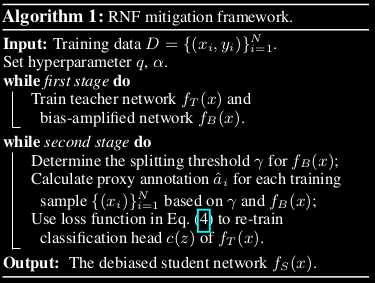

> We are not using bias amplified network here because it is required only if annotation of sensitive label is not available so as to create proxy annotation instead.






## Loss function

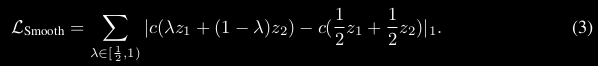

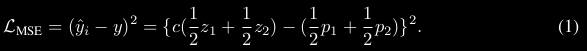

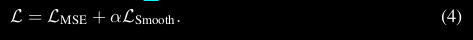

## Training Definition

In [ ]:
def train_epoch_progress(model, classification_head, train_iter, loss_function, optimizer, optimizer_head, epoch):
    
    # Doing training as normal
    model.train()
    classification_head.train()

    # If second stage, we want to freeze the model(Teacher Network)
    if epoch >= EPOCHS_first_stage:
        for param in model.parameters():
            param.requires_grad = False
        for param in classification_head.parameters():
            param.requires_grad = True

    avg_loss = 0.0
    truth_res = []
    pred_res = []
    softmax = nn.Softmax(dim=1)
    # wrapping in tqdm for fancy progress bar
    for batch in tqdm(train_iter, desc='Train epoch '+str(epoch+1)):
        # Pre-processing the data
        # batch[0], batch[1], batch[2] -> input values, ground truth value, sensitive input value
        sent, label, sensitive_label = batch[0], batch[1], batch[2]
        sent = sent.type(torch.cuda.FloatTensor)
        label = label.type(torch.cuda.LongTensor)
        sent = Variable(sent)       
        label = Variable(label)
        label = label.cpu()
        truth_res += list(label.data.numpy())
        sensitive_label = Variable(sensitive_label)

        # Get probability of the original input from the biased model
        sent = sent.cuda()
        pred, representation = model(sent)
        # A larger temperature prevents the model from assigning over-confident prediction probabilities
        # temperature = 1 means standard softmax
        pred_softmax = softmax(pred/temperature)
        pred_softmax = pred_softmax.cpu()
        
        
        # The first training stage
        if epoch < EPOCHS_first_stage:
            # Calculating accuracy
            pred = F.log_softmax(pred)
            pred = pred.cpu()
            pred_label = pred.data.max(1)[1].numpy()
            pred_res += [x for x in pred_label]

            # Update the parameters for the whole model
            model.zero_grad()
            loss = loss_function(pred, label)
            avg_loss += loss.data.item()
            loss.backward()
            optimizer.step()

        # The second training stage
        if epoch >= EPOCHS_first_stage:
            # Get the interpolated/neutralized features and probablity
            neutra_repre_5, neutra_repre_6, neutra_repre_7, neutra_repre_8, neutra_repre_9, neutra_probability5 = feature_neutralization(representation, pred_softmax, label, sensitive_label)       
            
            # Using knowledge distillation loss as in equation 1
            # The neutralized sample is with lambda = 0.5 while others form the augmented ones.
            pred_neutra = classification_head(neutra_repre_5)
            pred_neutra = softmax(pred_neutra)
            pred_neutra = pred_neutra.cpu()
            loss = kd_loss_function(neutra_probability5, pred_neutra)
            
            # Add regularization to smoothen neutralization as is done in equation 3
            augmented_list = []
            augmented_list.append(neutra_repre_6)
            augmented_list.append(neutra_repre_7)
            augmented_list.append(neutra_repre_8)
            augmented_list.append(neutra_repre_9)
            difference_sum = 0
            for i in range(4):
                pred_augmented = classification_head(augmented_list[i])
                pred_augmented = softmax(pred_augmented)
                pred_augmented = pred_augmented.cpu()
                difference_sum  += torch.abs(pred_augmented - pred_neutra)
            
            # Linearly combine two losses as is done in equation 4
            loss += alpha * torch.sum(difference_sum)
            avg_loss += loss.data.item()
            
            # Calculating accuracy
            pred, representation = model(sent)
            pred = classification_head(representation)
            pred = F.log_softmax(pred)
            pred = pred.cpu()
            pred_label = pred.data.max(1)[1].numpy()
            pred_res += [x for x in pred_label]

            # Update the classification head parameters(since it is second stage, we update only the classification head)
            classification_head.zero_grad()
            loss.backward()
            optimizer_head.step()
        
    avg_loss /= len(train_iter)
    acc = get_accuracy(truth_res, pred_res)
    return avg_loss, acc


## Feature Neutralization

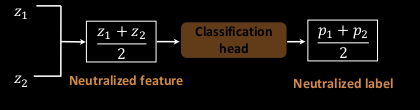

In [ ]:
# Representation neutralization
# Input: representation, prob after temperature scaling, ground truth value, sensitive input value 

def feature_neutralization(r_batch, p_batch, y_batch, a_batch):
  # Category differentiation based on y-label and _bias based on value of sensitive attribute
  category1_bias1 = []
  category1_bias2 = []
  category2_bias1 = []
  category2_bias2 = []

  # Categorizing by going through the whole batch and checking the values
  for i in range(a_batch.shape[0]):
    if y_batch[i].cpu().detach().numpy() == 0 and a_batch[i].cpu().detach().numpy() == 0:
      category1_bias1.append([r_batch[i], p_batch[i]])
    elif y_batch[i].cpu().detach().numpy() == 0 and a_batch[i].cpu().detach().numpy() == 1:
      category1_bias2.append([r_batch[i], p_batch[i]])
    elif y_batch[i].cpu().detach().numpy() == 1 and a_batch[i].cpu().detach().numpy() == 0:
      category2_bias1.append([r_batch[i], p_batch[i]])
    elif y_batch[i].cpu().detach().numpy() == 1 and a_batch[i].cpu().detach().numpy() == 1:
      category2_bias2.append([r_batch[i], p_batch[i]])
  
  # To store augmented neutralized sample representation generated based on different lambda value and input representations
  
  # lambda = 0.5
  neutralization_repre_5 = torch.zeros(a_batch.shape[0], HIDDEN_DIM)
  
  # lambda = 0.6
  neutralization_repre_6 = torch.zeros(a_batch.shape[0], HIDDEN_DIM)
  
  # lambda = 0.7
  neutralization_repre_7 = torch.zeros(a_batch.shape[0], HIDDEN_DIM)
  
  # lambda = 0.8
  neutralization_repre_8 = torch.zeros(a_batch.shape[0], HIDDEN_DIM)
  
  # lambda = 0.9
  neutralization_repre_9 = torch.zeros(a_batch.shape[0], HIDDEN_DIM)

  # To store neutralized probabilities for each class using input representations 
  neutralization_probability5 = torch.zeros(a_batch.shape[0], 2)

  # Taking volunteer from the opposite value of sensitive group for a given category to obtain neutralized values
  for i in range(a_batch.shape[0]):

    if y_batch[i].cpu().detach().numpy() == 0 and a_batch[i].cpu().detach().numpy() == 0:
      if len(category1_bias2) != 0:
        neutralization_sample = random.choice(category1_bias2)
      else:
        neutralization_sample = random.choice(category1_bias1)
    
        
    elif y_batch[i].cpu().detach().numpy() == 0 and a_batch[i].cpu().detach().numpy() == 1:
      if len(category1_bias1) != 0:
        neutralization_sample = random.choice(category1_bias1)
      else:
        neutralization_sample = random.choice(category1_bias2)

    elif y_batch[i].cpu().detach().numpy() == 1 and a_batch[i].cpu().detach().numpy() == 0:
      if len(category2_bias2) != 0:
        neutralization_sample = random.choice(category2_bias2)
      else:
        neutralization_sample = random.choice(category2_bias1)

    elif y_batch[i].cpu().detach().numpy() == 1 and a_batch[i].cpu().detach().numpy() == 1:
      if len(category2_bias1) != 0:
        neutralization_sample = random.choice(category2_bias1)
      else:
        neutralization_sample = random.choice(category2_bias2)
    
    # Storing augmented neutralized sample representation
    neutralization_repre_5[i] = 0.5 * r_batch[i] + 0.5 * neutralization_sample[0]
    neutralization_repre_6[i] = 0.6 * r_batch[i] + 0.4 * neutralization_sample[0]
    neutralization_repre_7[i] = 0.7 * r_batch[i] + 0.3 * neutralization_sample[0]
    neutralization_repre_8[i] = 0.8 * r_batch[i] + 0.2 * neutralization_sample[0]
    neutralization_repre_9[i] = 0.9 * r_batch[i] + 0.1 * neutralization_sample[0]
    
    # Storing neutralized probabilities
    neutralization_probability5[i] = 0.5 * p_batch[i] + 0.5 * neutralization_sample[1]
  
  neutralization_repre_5 = neutralization_repre_5.cuda()
  neutralization_repre_6 = neutralization_repre_6.cuda()
  neutralization_repre_7 = neutralization_repre_7.cuda()
  neutralization_repre_8 = neutralization_repre_8.cuda()
  neutralization_repre_9 = neutralization_repre_9.cuda()


  return neutralization_repre_5, neutralization_repre_6, neutralization_repre_7, neutralization_repre_8, neutralization_repre_9, neutralization_probability5


# Evaluation Definition

a) The evaluate_first_stage is used to predict the accuracy after running the dataset through the first stage only.

b) The evaluate_second_stage function is used to predict the accuracy after running the dataset through the classification head, after the first stage.
This is the final accuracy on the test data.

In [ ]:
def evaluate_first_stage(model, data, loss_function, name):
    model.eval()
    avg_loss = 0.0
    truth_res = []
    pred_res = []
    for batch in data:
        sent, label, sensitive_label = batch[0], batch[1], batch[2]
        sent = sent.type(torch.cuda.FloatTensor)
        label = label.type(torch.cuda.LongTensor)
        sent = Variable(sent)
        label = Variable(label)
        truth_res += list(label.data)
        model.batch_size = len(label.data)
        sent = sent.cuda()
        pred, representation = model(sent)
        pred = F.log_softmax(pred)
        pred = pred.cpu()
        pred_label = pred.data.max(1)[1].numpy()
        pred_res += [x for x in pred_label]
        label = label.cpu()
        loss = loss_function(pred, label)
        avg_loss += loss.data.item()
    avg_loss /= len(data)
    acc = get_accuracy(truth_res, pred_res)
    print(name + ': loss %.2f acc %.1f' % (avg_loss, acc*100))
    return acc


def evaluate_second_stage(model, classification_head, data, loss_function, name):
    model.eval()
    classification_head.eval()
    avg_loss = 0.0
    truth_res = []
    pred_res = []
    for batch in data:
        sent, label, sensitive_label = batch[0], batch[1], batch[2]
        sent = sent.type(torch.cuda.FloatTensor)
        label = label.type(torch.cuda.LongTensor)
        sent = Variable(sent)
        label = Variable(label)
        truth_res += list(label.cpu().data.numpy())
        model.batch_size = len(label.data)
        sent = sent.cuda()
        pred, representation = model(sent)
        #pred = classification_head(representation)
        pred = F.log_softmax(pred)
        pred = pred.cpu()
        pred_label = pred.data.max(1)[1].numpy()
        pred_res += [x for x in pred_label]
        label = label.cpu()
        loss = loss_function(pred, label)
        avg_loss += loss.data.item()
    avg_loss /= len(data)
    acc = get_accuracy(truth_res, pred_res)
    print(name + ': loss %.2f acc %.1f' % (avg_loss, acc*100))
    return acc,pred_res

# Declaring Hyperparameters

In [ ]:
EPOCHS_first_stage = 50
EPOCHS_second_stage = 0
USE_GPU = torch.cuda.is_available()
HIDDEN_DIM = 10
BATCH_SIZE = 64
INPUT_DIM = 10
alpha = 0.0005 # This is the value in Equation 4 to control the fairness accuracy trade-off
temperature = 5 # Temperature scaling


# Training & Testing

We call the train_epoch_progress function defined above for the training of our data. PyTorch’s automatic differentiation engine ‘autograd’ is being used for performing the batch gradient descent.

In [ ]:
# Loading dataset in batch fashion
train_iter, dev_iter, test_iter = load_lawgpa(BATCH_SIZE)

In [ ]:
# Declaring model, classification head, optimizer, loss functions, knowledge distillation loss function etc. to apply RNF framework on.
model = Net(INPUT_DIM, HIDDEN_DIM, 2)
classification_head = FC(INPUT_DIM, HIDDEN_DIM, 2)
if USE_GPU:
    model = model.cuda()
    classification_head = classification_head.cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
optimizer_head = optim.Adam(classification_head.parameters(), lr=1e-3)
loss_function = nn.NLLLoss()
kd_loss_function = nn.MSELoss()

In [ ]:
# Training
print('Training...')
for epoch in range(EPOCHS_first_stage+EPOCHS_second_stage):
    avg_loss, acc = train_epoch_progress(model, classification_head, train_iter, loss_function, optimizer, optimizer_head, epoch)
    tqdm.write('Train: loss %.2f acc %.1f' % (avg_loss, acc*100))
dev_acc = evaluate_second_stage(model, classification_head, dev_iter, loss_function, 'Dev')

Training...


Train epoch 1: 100%|██████████| 211/211 [00:01<00:00, 118.29it/s]


Train: loss 0.61 acc 68.3


Train epoch 2: 100%|██████████| 211/211 [00:01<00:00, 143.03it/s]


Train: loss 0.53 acc 75.9


Train epoch 3: 100%|██████████| 211/211 [00:01<00:00, 161.31it/s]


Train: loss 0.50 acc 78.6


Train epoch 4: 100%|██████████| 211/211 [00:01<00:00, 197.62it/s]


Train: loss 0.48 acc 79.6


Train epoch 5: 100%|██████████| 211/211 [00:01<00:00, 150.28it/s]


Train: loss 0.46 acc 80.6


Train epoch 6: 100%|██████████| 211/211 [00:01<00:00, 175.22it/s]


Train: loss 0.46 acc 80.9


Train epoch 7: 100%|██████████| 211/211 [00:01<00:00, 182.52it/s]


Train: loss 0.45 acc 81.4


Train epoch 8: 100%|██████████| 211/211 [00:00<00:00, 385.95it/s]


Train: loss 0.44 acc 82.0


Train epoch 9: 100%|██████████| 211/211 [00:00<00:00, 378.82it/s]


Train: loss 0.43 acc 82.2


Train epoch 10: 100%|██████████| 211/211 [00:00<00:00, 379.91it/s]


Train: loss 0.42 acc 82.9


Train epoch 11: 100%|██████████| 211/211 [00:00<00:00, 391.98it/s]


Train: loss 0.42 acc 83.0


Train epoch 12: 100%|██████████| 211/211 [00:00<00:00, 377.21it/s]


Train: loss 0.42 acc 83.3


Train epoch 13: 100%|██████████| 211/211 [00:00<00:00, 390.26it/s]


Train: loss 0.41 acc 83.1


Train epoch 14: 100%|██████████| 211/211 [00:00<00:00, 387.55it/s]


Train: loss 0.39 acc 83.5


Train epoch 15: 100%|██████████| 211/211 [00:00<00:00, 388.61it/s]


Train: loss 0.38 acc 83.4


Train epoch 16: 100%|██████████| 211/211 [00:00<00:00, 382.06it/s]


Train: loss 0.37 acc 83.4


Train epoch 17: 100%|██████████| 211/211 [00:00<00:00, 391.08it/s]


Train: loss 0.35 acc 83.5


Train epoch 18: 100%|██████████| 211/211 [00:00<00:00, 385.57it/s]


Train: loss 0.34 acc 83.6


Train epoch 19: 100%|██████████| 211/211 [00:00<00:00, 372.51it/s]


Train: loss 0.33 acc 83.7


Train epoch 20: 100%|██████████| 211/211 [00:00<00:00, 382.09it/s]


Train: loss 0.32 acc 83.8


Train epoch 21: 100%|██████████| 211/211 [00:00<00:00, 373.85it/s]


Train: loss 0.31 acc 83.9


Train epoch 22: 100%|██████████| 211/211 [00:00<00:00, 372.61it/s]


Train: loss 0.30 acc 84.0


Train epoch 23: 100%|██████████| 211/211 [00:00<00:00, 387.87it/s]


Train: loss 0.30 acc 83.9


Train epoch 24: 100%|██████████| 211/211 [00:00<00:00, 399.90it/s]


Train: loss 0.29 acc 84.1


Train epoch 25: 100%|██████████| 211/211 [00:00<00:00, 392.04it/s]


Train: loss 0.29 acc 84.5


Train epoch 26: 100%|██████████| 211/211 [00:00<00:00, 381.81it/s]


Train: loss 0.28 acc 86.7


Train epoch 27: 100%|██████████| 211/211 [00:00<00:00, 380.61it/s]


Train: loss 0.28 acc 87.8


Train epoch 28: 100%|██████████| 211/211 [00:00<00:00, 382.38it/s]


Train: loss 0.28 acc 88.4


Train epoch 29: 100%|██████████| 211/211 [00:00<00:00, 383.81it/s]


Train: loss 0.27 acc 89.1


Train epoch 30: 100%|██████████| 211/211 [00:00<00:00, 384.55it/s]


Train: loss 0.27 acc 89.8


Train epoch 31: 100%|██████████| 211/211 [00:00<00:00, 391.13it/s]


Train: loss 0.26 acc 89.3


Train epoch 32: 100%|██████████| 211/211 [00:00<00:00, 376.42it/s]


Train: loss 0.27 acc 89.2


Train epoch 33: 100%|██████████| 211/211 [00:00<00:00, 388.05it/s]


Train: loss 0.26 acc 89.2


Train epoch 34: 100%|██████████| 211/211 [00:00<00:00, 386.45it/s]


Train: loss 0.25 acc 89.5


Train epoch 35: 100%|██████████| 211/211 [00:00<00:00, 390.71it/s]


Train: loss 0.26 acc 89.6


Train epoch 36: 100%|██████████| 211/211 [00:00<00:00, 383.33it/s]


Train: loss 0.25 acc 89.5


Train epoch 37: 100%|██████████| 211/211 [00:00<00:00, 394.84it/s]


Train: loss 0.26 acc 89.8


Train epoch 38: 100%|██████████| 211/211 [00:00<00:00, 388.76it/s]


Train: loss 0.25 acc 89.3


Train epoch 39: 100%|██████████| 211/211 [00:00<00:00, 388.95it/s]


Train: loss 0.25 acc 89.9


Train epoch 40: 100%|██████████| 211/211 [00:00<00:00, 389.76it/s]


Train: loss 0.25 acc 89.5


Train epoch 41: 100%|██████████| 211/211 [00:00<00:00, 389.94it/s]


Train: loss 0.25 acc 89.9


Train epoch 42: 100%|██████████| 211/211 [00:00<00:00, 399.06it/s]


Train: loss 0.25 acc 90.1


Train epoch 43: 100%|██████████| 211/211 [00:00<00:00, 386.06it/s]


Train: loss 0.24 acc 90.0


Train epoch 44: 100%|██████████| 211/211 [00:00<00:00, 387.93it/s]


Train: loss 0.24 acc 90.3


Train epoch 45: 100%|██████████| 211/211 [00:00<00:00, 376.82it/s]


Train: loss 0.23 acc 90.8


Train epoch 46: 100%|██████████| 211/211 [00:00<00:00, 393.50it/s]


Train: loss 0.24 acc 90.1


Train epoch 47: 100%|██████████| 211/211 [00:00<00:00, 388.73it/s]


Train: loss 0.24 acc 90.4


Train epoch 48: 100%|██████████| 211/211 [00:00<00:00, 381.47it/s]


Train: loss 0.23 acc 90.2


Train epoch 49: 100%|██████████| 211/211 [00:00<00:00, 377.85it/s]


Train: loss 0.24 acc 90.0


Train epoch 50: 100%|██████████| 211/211 [00:00<00:00, 381.07it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train: loss 0.24 acc 90.1
Dev: loss 0.18 acc 93.2


In [ ]:
# Testing
test_acc,pred_res = evaluate_second_stage(model, classification_head, test_iter, loss_function, 'Final Test')

Final Test: loss 0.17 acc 93.7


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


accuracy          0.937291
selection rate    0.710333
count                 4481
dtype: object
        accuracy selection rate count
gender                               
0       0.943669       0.766925  1935
1       0.932443       0.667321  2546


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb5098ca350>],
      dtype=object)

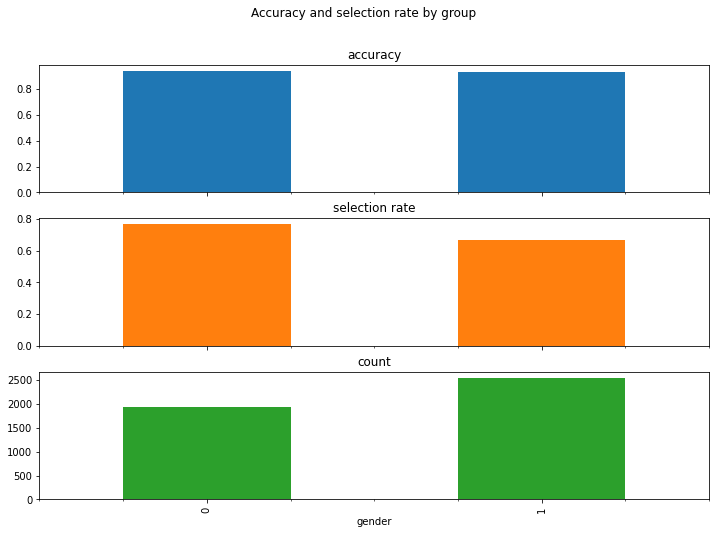

In [ ]:
from sklearn import metrics as skm
from fairlearn.reductions import DemographicParity, ErrorRate
from fairlearn.metrics import MetricFrame, selection_rate, count,equalized_odds_difference,demographic_parity_difference
metric_frame = MetricFrame(metrics={"accuracy": skm.accuracy_score,
                                    "selection rate": selection_rate,
                                    "count": count},
                           sensitive_features=test['gender'],
                           y_true=test['ugpa'],
                           y_pred=pred_res)
print(metric_frame.overall)
print(metric_frame.by_group)
metric_frame.by_group.plot.bar(
        subplots=True, layout=[3, 1], legend=False, figsize=[12, 8],
        title='Accuracy and selection rate by group')


In [ ]:
    print(
        "demographic parity difference (test): %.2f"
        % demographic_parity_difference(
            y_true=test['ugpa'],
            y_pred=pred_res,
            sensitive_features=test['gender'],
        )
    )


demographic parity difference (test): 0.10
